# APPM4058A & COMS7238A: Digital Image Processing Assignment 1


## <font color = "#434343">1 - Histogram Processing</font>

#### <font color = "#434343"> Libraries</font>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage.exposure import cumulative_distribution
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import signal
from skimage.exposure import match_histograms

# If outputs are small when first run, please re-run those specifice cells using ctrl+enter rather then shift+enter

#### <font color = "#434343">Loading Images</font>

In [5]:
poppies = imread('./images/poppies.png')
cherry_tree = imread('./images/cherry_tree.png')

hidden_horse = imread('./images/hidden-horse.tif')
totem_poles = imread('./images/totem-poles.tif')

hiddenroad_low_2horse = imread('./images/road_low_2.jpg')
national_archives_bld = imread('./images/national-archives-bld.tif')

lavender = imread('./images/lavender.png')

car= imread('./images/car_75DPI_Moire.tif')

#### <font color = "#434343">Averaging Filters</font>

In [6]:
w1 = 1*np.array([[1]])
w2 = (1/5)*np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]])
w3 = (1/9)*np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]])
w4 = (1/13)*np.array([[0, 0, 1, 0, 0],[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[0, 1, 1, 1, 0],
                      [0, 0, 1, 0, 0]])
w5 = (1/21)*np.array([[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],
                      [0, 1, 1, 1, 0]])
w6 =(1.0/25)*np.array([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1]])
aveFilters = {1: [w1], 2: [w1,w2], 3: [w1,w2,w3], 4: [w1,w2,w3,w4], 5: [w1,w2,w3,w4,w5],
              6: [w1,w2,w3,w4,w5,w6]}

#### <font color = "#434343">Functions used in this notebook</font>

In [13]:
# Generates a histogram of an image
def histogramify(image):
    histogram = np.empty((256))
    for grays in range(0, 256):
        histogram[grays] = len(image[image == grays])

    return histogram

def aveFiltersApplied(img, kernels):
    vals = np.array([signal.convolve2d(img, kernel, 'same') for kernel in kernels])
    return vals

def lexiSort(matrix):
    rotmatrix = np.rot90(matrix)
    index = np.lexsort(rotmatrix)
    return matrix[index]

# Discret Fourier Transfrom
def DFT(image):
    return np.fft.fftshift(np.fft.fft2(image))

# inverse DFT
def iDFT(image):
    return np.fft.ifft2(image)

# adds padding around an image using the edge mode
def padding(image):
    p = np.pad(image, 1, mode='edge')
    return p

#generates a notch filters
def notchFilter(shape, D0, uk, vk):
    M, N = shape
    Huv = np.zeros((M, N))

    for u in range(0, M):
        for v in range(0, N):
            D_vek = np.sqrt((u-M/2+uk)**2 + (v-N/2+vk)**2)
            D_k = np.sqrt((u-M/2-uk)**2 + (v-N/2-vk)**2)
            Huv[u,v] += ((1/(1+(D0/D_k)**4))*(1/(1+(D0/D_vek)**4))) 

    return Huv

def avePixels(imgage, K):
    kernels = aveFilters[K]
    aveImages = aveFiltersApplied(imgage, kernels)
    img_size = aveImages[0].shape[0] * aveImages[0].shape[1]
    reshapedAveImages = aveImages.reshape((K, img_size))
    transposedAveImages = reshapedAveImages.transpose()
    return transposedAveImages

def BRB(image,D0,W,n):
    paddedImaged = padding(image)
    m = paddedImaged.shape[0]
    n = paddedImaged.shape[1]
    Huv = np.zeros((m, n))
    
    for u in range(0,m):
        for v in range(0,n):
            D = np.sqrt((u-m/2)**2+(v-n/2)**2)
            Huv[u,v]+=(1/(1+(D*W/(D**2-D0**2)**(2*n))))
    
    return Huv

#applies the BRB filter generated as a result of the above functions
def applyBRB(image, brb):
    p = padding(image)
    dft = DFT(p)
    G = np.multiply(brb,dft)
    Gi = iDFT(G)
    S = np.log(1+abs(Gi))
    return S

def exact_histogram_matching(image, im_target, K):
    refHistogram = histogramify(im_target)
    size = image.shape[0] * image.shape[1]
    merged = np.empty((size, K + 2))
    merged[:, 0] = image.reshape((size,))
    flattenedImage = np.arange(size).transpose()
    merged[:, -1] = flattenedImage
    aveImages = avePixels(image, K)
    
    for dimension in range(0, K):
        merged[:, dimension + 1] = aveImages[:, dimension]

    sortedMerged = lexiSort(merged)
    start = 0
    
    for gray_value in range(0, len(refHistogram)):
        end = int(start + refHistogram[gray_value])
        sortedMerged[start:end, 0] = gray_value
        start = end

    sortedMerged = sortedMerged[sortedMerged[:, -1].argsort()]
    result = sortedMerged[:, 0].reshape(image.shape)

    return result

# Generates the cumulative distribution function of an image
def getCDF(image):
    hist,bins = np.histogram(image.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_norm = cdf * hist.max()/ cdf.max()
    
    return cdf_norm

### <font color = "#434343">1.1 Exact Histogram Matching by _Coltuc_</font>

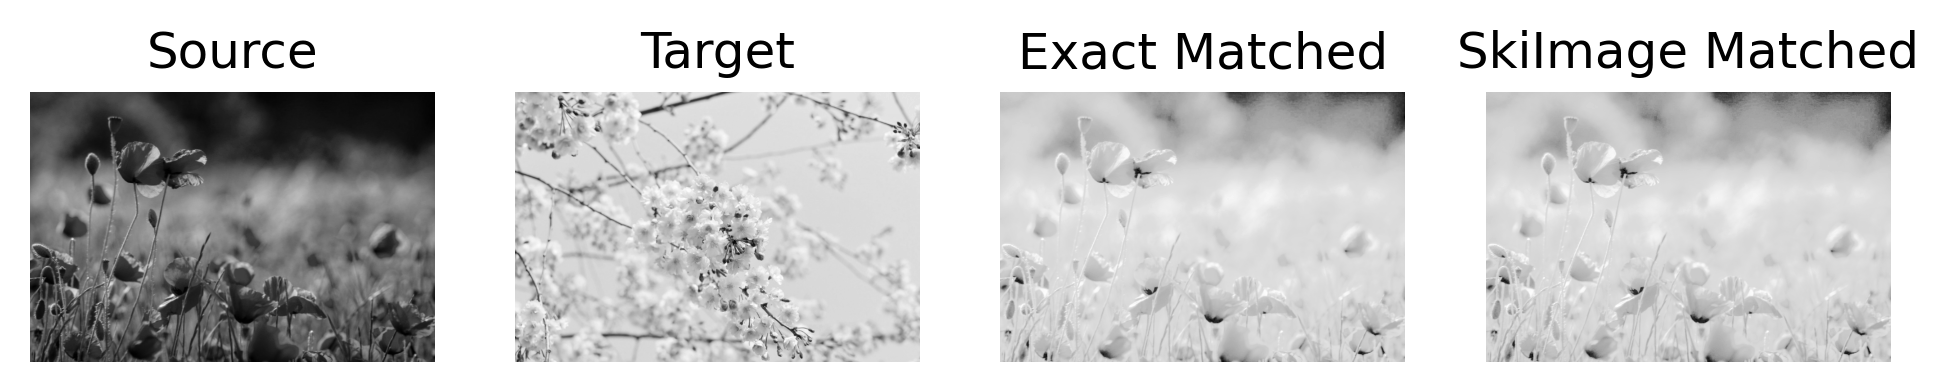

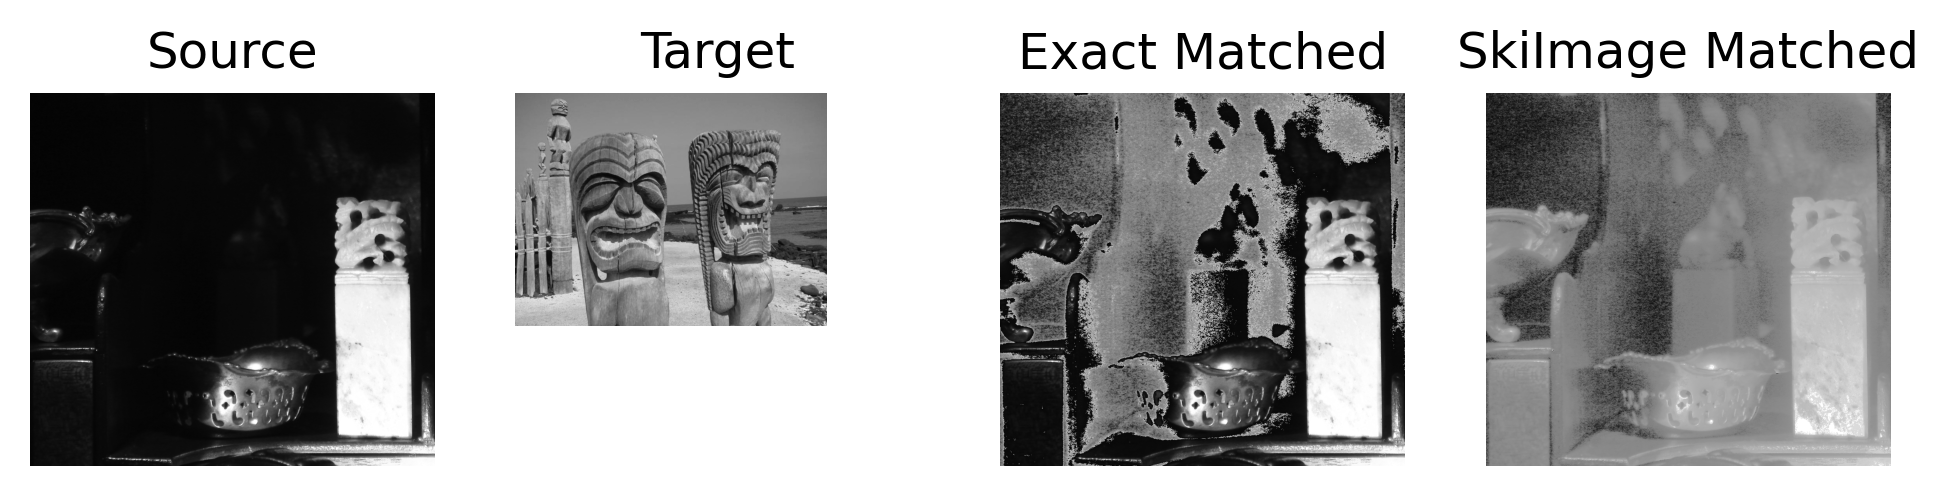

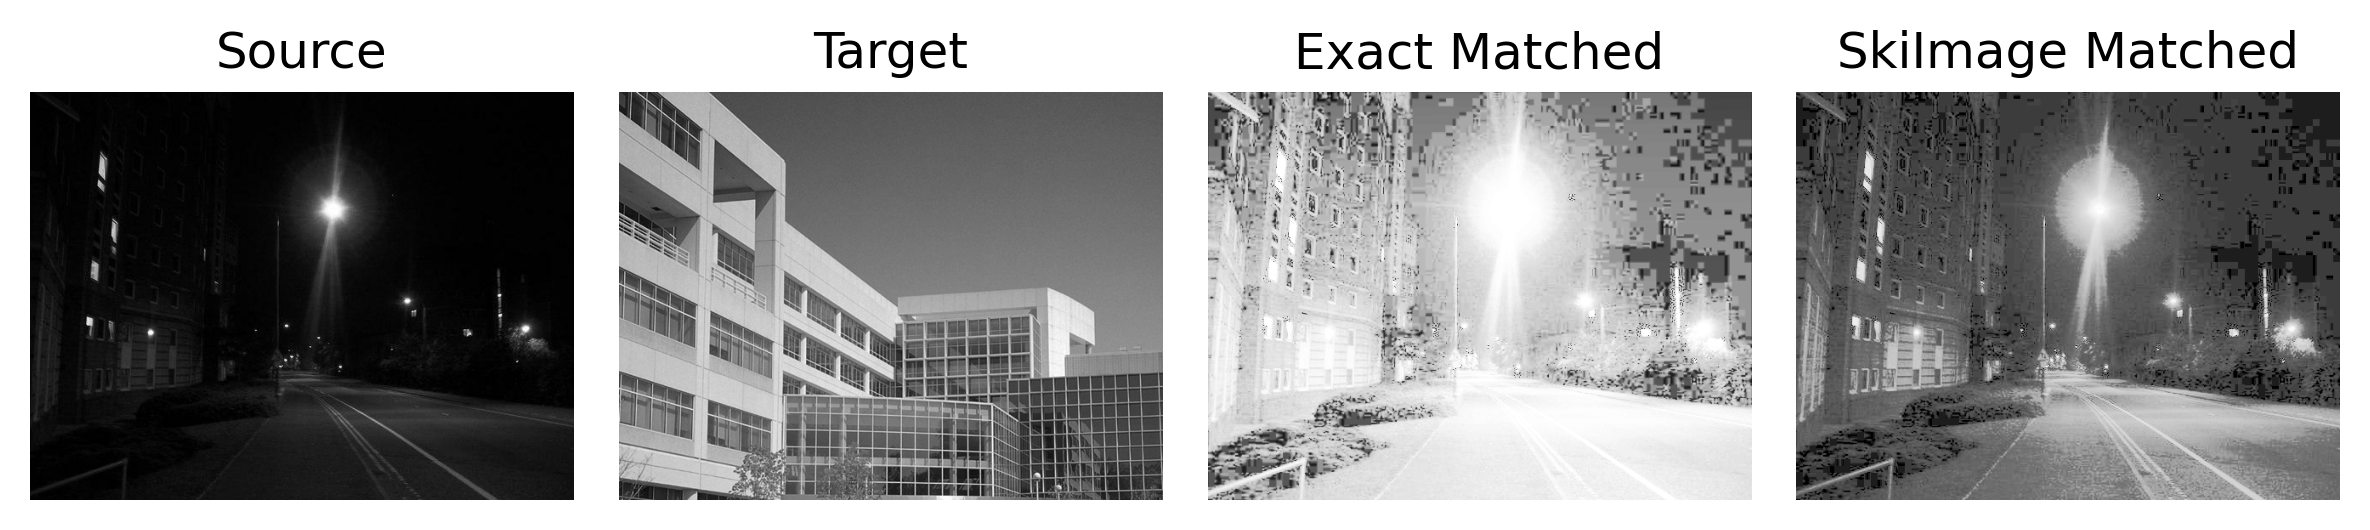

In [7]:
fig, (ax1,ax2,ax3,m1) = plt.subplots(nrows=1, ncols= 4, figsize=(8,3), sharex=True, sharey=True)

for aa in (ax1,ax2,ax3,m1):
    aa.set_axis_off()

ax1.imshow(poppies, cmap='gray')
ax1.set_title('Source')

ax2.imshow(cherry_tree, cmap='gray')
ax2.set_title('Target')

ematch1 = exact_histogram_matching(poppies, cherry_tree,6) # histo matching using exact matching implementation
ax3.imshow(ematch1, cmap='gray')
ax3.set_title('Exact Matched')

match1 = match_histograms(poppies, cherry_tree) # histo matching using built in skiImage matching
m1.imshow(match1,cmap='gray')
m1.set_title('SkiImage Matched')

#########################################################################################################

fig, (ax4,ax5,ax6,m2) = plt.subplots(nrows=1, ncols= 4, figsize=(8,3), sharex=True, sharey=True)
#(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9)
for aa in (ax4,ax5,ax6,m2):
    aa.set_axis_off()

ax4.set_title('Source')
ax4.imshow(hidden_horse, cmap='gray')

ax5.set_title('Target')
ax5.imshow(totem_poles, cmap='gray')

ax6.set_title('Exact Matched')
ematch2 = exact_histogram_matching(hidden_horse, totem_poles,3) # histo matching using exact matching implementation
ax6.imshow(ematch2, cmap='gray')

match2 = match_histograms(hidden_horse, totem_poles) # histo matching using built in skiImage matching
m2.imshow(match2,cmap='gray')
m2.set_title('SkiImage Matched')

#########################################################################################################

fig, (ax7,ax8,ax9,m3) = plt.subplots(nrows=1, ncols= 4, figsize=(8,3), sharex=True, sharey=True)
#(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9)
for aa in (ax7,ax8,ax9,m3):
    aa.set_axis_off()

ax7.imshow(hiddenroad_low_2horse, cmap='gray')
ax7.set_title('Source')

ax8.imshow(national_archives_bld, cmap='gray')
ax8.set_title('Target')

ematch3 = exact_histogram_matching(hiddenroad_low_2horse, national_archives_bld,3)#histo matching using exact matching implementation
ax9.imshow(ematch3, cmap='gray')
ax9.set_title('Exact Matched')

match3 = match_histograms(hiddenroad_low_2horse, national_archives_bld)# histo matching using built in skiImage matching
m3.imshow(match3,cmap='gray')
m3.set_title('SkiImage Matched')

plt.tight_layout()
plt.rcParams['figure.dpi'] = 300


### <font color = "#434343">1.2 Analysis of Histograms</font>

#### <font color = "#434343">Since the histogram of the source is exactly matched to the target their histograms and CDF's are almost identical</font>

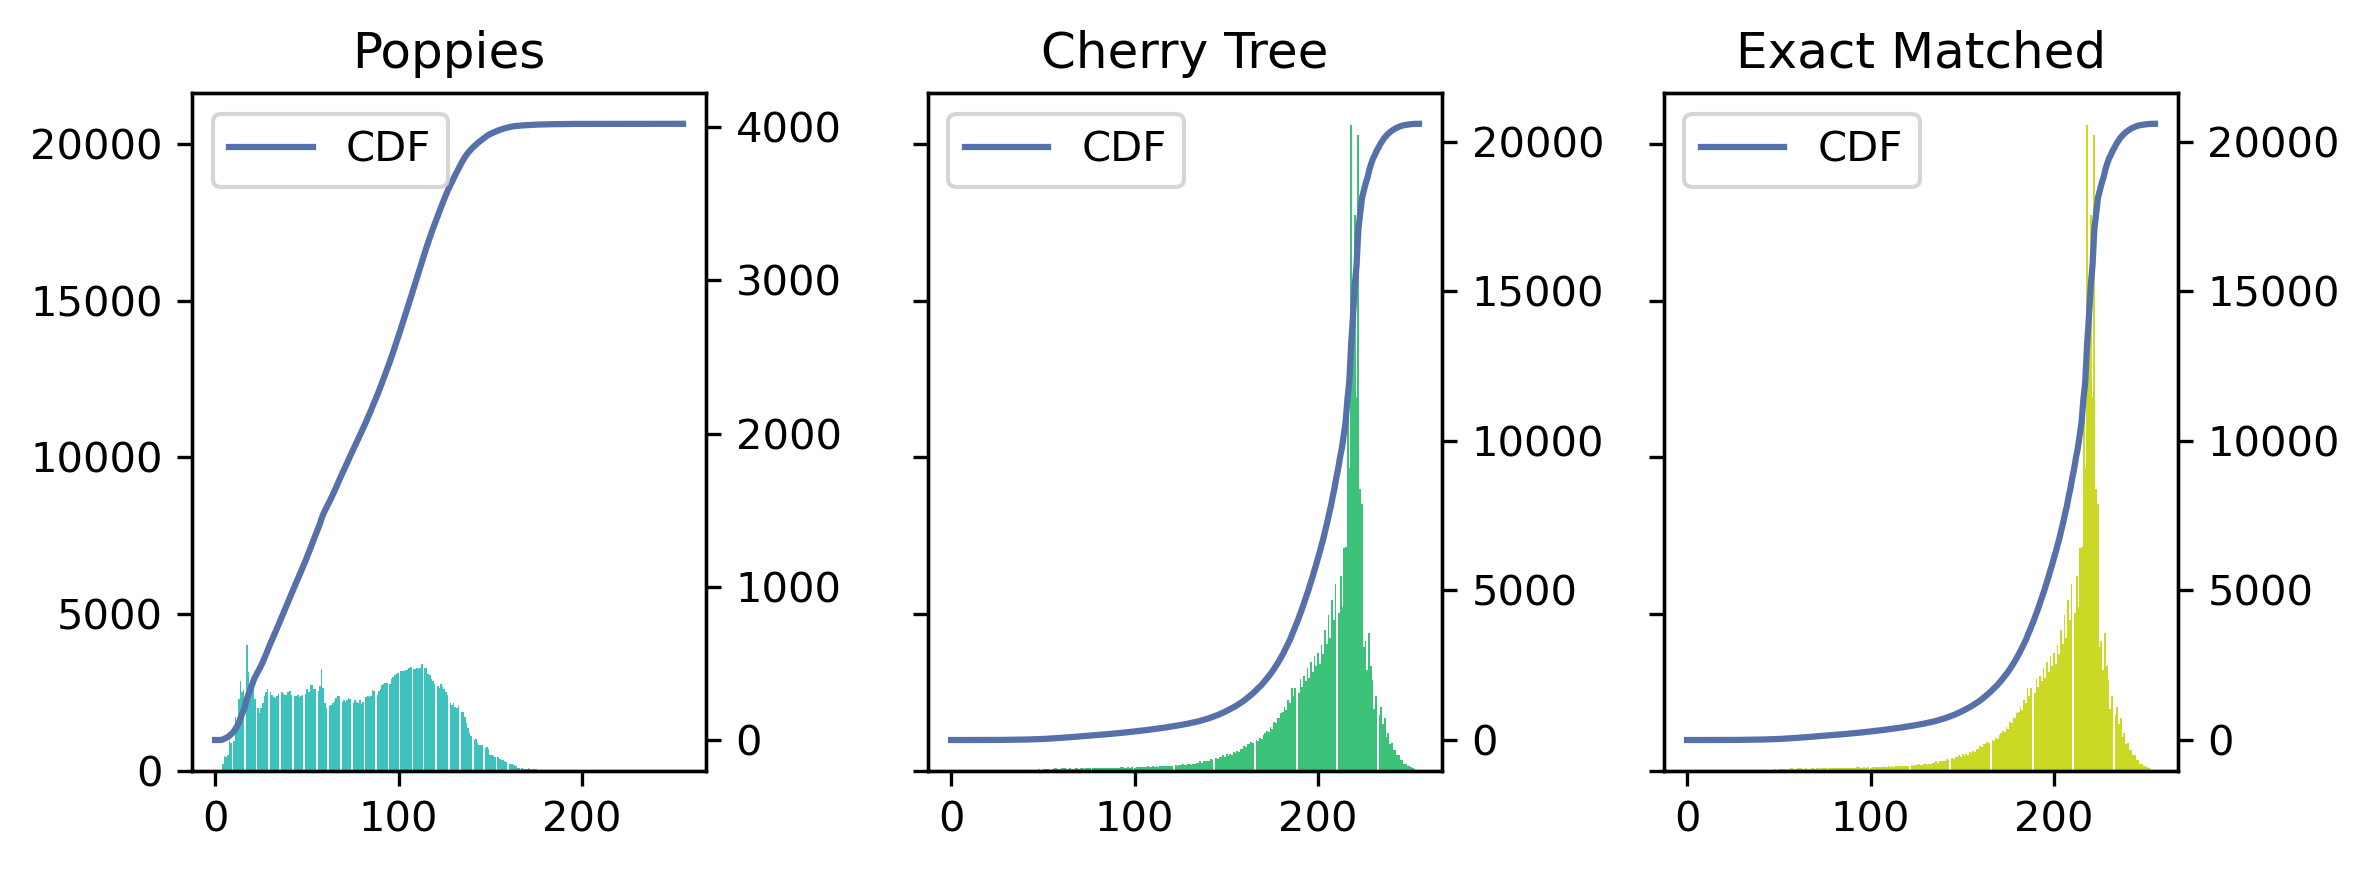

In [8]:
fig, (h1,h2,h3) = plt.subplots(nrows=1, ncols= 3, figsize=(8,3), sharex=True, sharey=True)

cdfPoppies = getCDF(poppies)
h1.hist(poppies.ravel(), bins=256,color='#3dc2bd')
h11 = h1.twinx()
h11.plot(cdfPoppies, color = '#5670a9', label='CDF')
h11.legend()
h1.set_title('Poppies')

cdfCherry = getCDF(cherry_tree)
h2.hist(cherry_tree.ravel(), bins=256, color='#3dc27a')
h21 = h2.twinx()
h21.plot(cdfCherry, color = '#5670a9', label='CDF')
h21.legend()
h2.set_title('Cherry Tree')


cdfematch1 = getCDF(ematch1)
h3.hist(ematch1.ravel(), bins=256, color='#cad926')
h31 = h3.twinx()
h31.plot(cdfematch1, color = '#5670a9', label='CDF')
h31.legend()
h3.set_title('Exact Matched')

plt.tight_layout()

# Since the histogram of the source is exactly matched to the target their histograms and CDF's are almost identical

## <font color = "#434343">2 - Frequency-domain Filtering</font>

### <font color = "#434343">2.1 Bandreject Butterworth Filter</font>

#### <font color = "#434343">The _Butterworth_ filter is generated by "BRB" then this filter is applied to the original image by "applyBRB". This is done 5 times to prodduce 5 different outputs with $D_0$ = {0, 10, 25, 50, 150} and W = {5, 25, 50, 100, 200} </font>

#### <font color = "#434343">In the results we see the filter and the output image. Even tho at first glance major differences cannot be seen, but according to the filters there is some difference</font>

C:\Users\Rushil\AppData\Local\Temp/ipykernel_7036/2468949974.py:61: RuntimeWarning: overflow encountered in double_scalars
  Huv[u,v]+=(1/(1+(D*W/(D**2-D0**2)**(2*n))))
C:\Users\Rushil\AppData\Local\Temp/ipykernel_7036/2468949974.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  Huv[u,v]+=(1/(1+(D*W/(D**2-D0**2)**(2*n))))


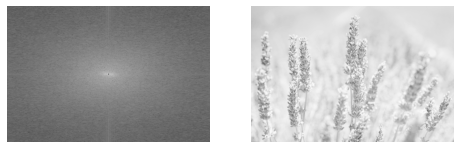

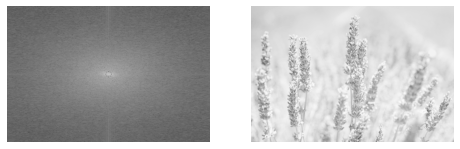

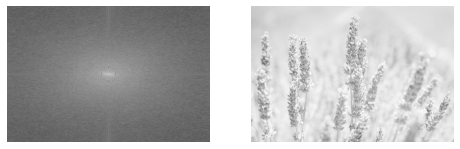

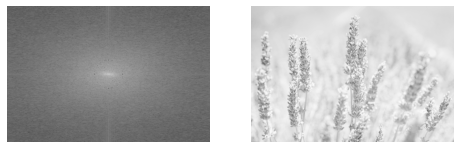

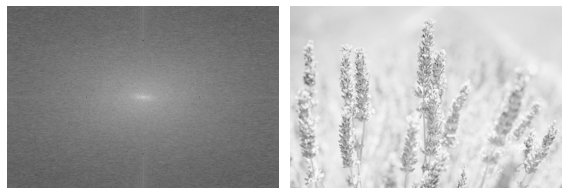

In [15]:
fshift = DFT(padding(lavender))
originalFourier = np.log(np.abs(1+fshift))
 
b1 = BRB(lavender,1,5,2)
dw1=applyBRB(lavender, b1)

b2 = BRB(lavender,10,25,2)
dw2=applyBRB(lavender, b1)

b3 = BRB(lavender,25,50,2)
dw3=applyBRB(lavender, b1)

b4 = BRB(lavender,50,100,2)
dw4=applyBRB(lavender, b1)

b5 = BRB(lavender,150,200,2)
dw5=applyBRB(lavender, b1)

# Plotting of Results
fig, (cx1,cx2) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)
for bb in (cx1,cx2):
    bb.set_axis_off()

cx2.imshow(dw1, cmap = 'gray')
cx1.imshow(originalFourier*b1, cmap = 'gray')

fig, (cx3,cx4) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)
for bb in (cx3,cx4):
    bb.set_axis_off()

cx4.imshow(dw2, cmap = 'gray')
cx3.imshow(originalFourier*b2, cmap = 'gray')

fig, (cx5,cx6) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)
for bb in (cx5,cx6):
    bb.set_axis_off()
    
cx6.imshow(dw3, cmap = 'gray')
cx5.imshow(originalFourier*b3, cmap = 'gray')
    

fig, (cx7,cx8) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)
for bb in (cx7,cx8):
    bb.set_axis_off()
    
cx8.imshow(dw4, cmap = 'gray')
cx7.imshow(originalFourier*b4, cmap = 'gray')

fig, (cx9,cx10) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)
for bb in (cx9,cx10):
    bb.set_axis_off()
    
cx10.imshow(dw5, cmap = 'gray')
cx9.imshow(originalFourier*b5, cmap = 'gray')

plt.tight_layout()

### 2.2 Notch Filtering


#### <font color = "#434343">In this filter we have 4 notches that we see in Fourier. All of their locations i.e u and v have been pre-determined by trial and error</font>

C:\Users\Rushil\AppData\Local\Temp/ipykernel_7036/2468949974.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  Huv[u,v] += ((1/(1+(D0/D_k)**4))*(1/(1+(D0/D_vek)**4)))


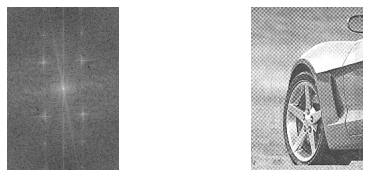

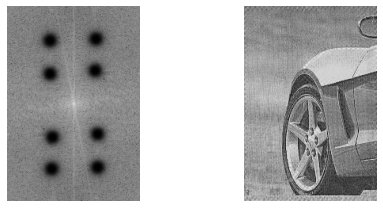

In [17]:
fshift = DFT(car)
oFourier = np.log(np.abs(1+fshift))
shape = car.shape

N1 = notchFilter(shape, 9, 38, 30) #Notch 1
N2 = notchFilter(shape, 9, -42, 27) #Notch 2
N3 = notchFilter(shape, 9, 80, 30) #Notch 3
N4 = notchFilter(shape, 9, -82, 28) #Notch 4

Filter = N1*N2*N3*N4
void = fshift * Filter 
reject = np.fft.ifftshift(void)
ireject = iDFT(reject)
output = np.abs(ireject)

# Plotting of Results -- nothing fancy 
fig, (nx1,nx2) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)

for cc in (nx1,nx2):
    cc.set_axis_off()

nx2.imshow(car, cmap = 'gray')
nx1.imshow(oFourier, cmap = 'gray')

fig, (nx3,nx4) = plt.subplots(nrows=1, ncols= 2, figsize=(8,3), sharex=True, sharey=True)

for cc in (nx3,nx4):
    cc.set_axis_off()

nx3.imshow(oFourier*Filter, cmap = 'gray')
nx4.imshow(output, cmap = 'gray')

plt.tight_layout()

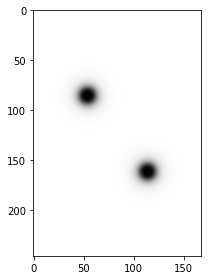

In [18]:
imshow(N1)